In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
import pandas as pd
from dask import delayed
from sdt_dask.clients.local import Local
from solardatatools import DataHandler
from sdt_dask.dataplugs.pvdaq_plug import PVDAQPlug

# Import user-defined dataplug

## Pull from PVDAQ

In [4]:
PVDAQPlug?

Init signature: PVDAQPlug(api_key='DEMO_KEY', power_col='ac_power')
Docstring:     
Dataplug class for retrieving data from the PVDAQ DB.
Note that the DEMO_KEY has a rate limit of 30/h, 50/d per IP address.
File:           c:\users\zander\documents\slac\solar-data-tools-develop-dask\sdt_dask\dataplugs\pvdaq_plug.py
Type:           type
Subclasses:     

In [5]:
data_plug = PVDAQPlug()

In [6]:
KEYS = [(34, 2011), (35, 2015), (51,2012)] # site ID and year pairs
KEYS

[(34, 2011), (35, 2015), (51, 2012)]

In [7]:
data_plug.get_data(KEYS[1])

[============================================================] 100.0% ...queries complete in 1.6 seconds       



,ac_power
2015-01-01 00:00:00,-300.0
2015-01-01 00:15:00,-300.0
2015-01-01 00:30:00,-200.0
2015-01-01 00:45:00,-300.0
2015-01-01 01:00:00,-300.0
...,...
2015-12-31 22:45:00,-200.0
2015-12-31 23:00:00,-300.0
2015-12-31 23:15:00,-200.0
2015-12-31 23:30:00,-200.0


# Create SDT Dask task graph (run in parallel on multiple files)

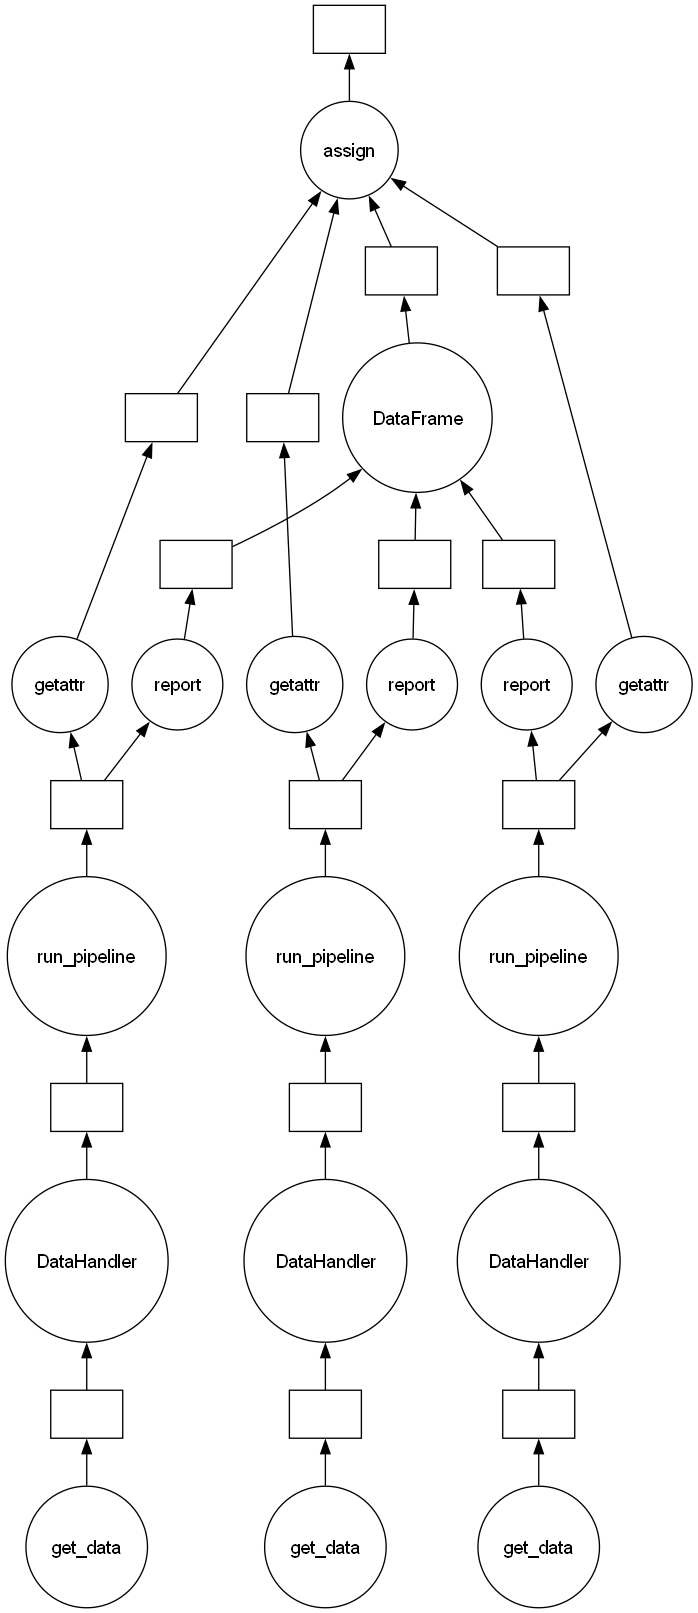

In [8]:
# Define the pipeline run for as single dataset
def run_pipeline(datahandler, solver, solver_convex, verbose=False):
    # Need to call this separately to have it run correctly in task graph 
    # since it doesn't return anything
    datahandler.run_pipeline(solver=solver, solver_convex=solver_convex, verbose=verbose)
    return datahandler


# Call above functions in a for loop over the keys
# and collect results in a DataFrame
reports = []
runtimes = []

for key in KEYS:
    
    df = delayed(data_plug.get_data)(key)
    dh = delayed(DataHandler)(df)
    dh_run = delayed(run_pipeline)(dh, solver="OSQP", solver_convex="OSQP", verbose=True)
    report = dh_run.report
    runtime = dh_run.total_time
    
    report = delayed(report)(return_values=True, verbose=False)
    runtime = delayed(runtime)
    
    reports.append(report)
    runtimes.append(runtime)


df_reports = delayed(pd.DataFrame)(reports)
df_reports = delayed(df_reports.assign)(runtime=runtimes, keys=KEYS)

# Visualizing the graph
df_reports.visualize()

# Get User-defined Client

In [9]:
n_workers = 3
threads_per_worker = 1
memory_per_worker = 7

In [10]:
client = Local().init_client(n_workers=n_workers, 
                             threads_per_worker=threads_per_worker,
                             memory_per_worker=memory_per_worker,
                             verbose = True)

[i] System: windows
[i] CPU Count: 16
[i] Memory: 31
[i] Workers: 3
[i] Threads per Worker: 1
[i] Memory per Worker: 7

[>] Dask Dashboard: http://192.168.1.157:8787/status



c:\Users\Zander\anaconda3\envs\pvi-user\lib\site-packages\distributed\worker_memory.py:494: FutureWarning: Parameter memory_target_fraction has been deprecated and will be removed in a future version; please use dask config key distributed.worker.memory.target instead
  warnings.warn(
c:\Users\Zander\anaconda3\envs\pvi-user\lib\site-packages\distributed\worker_memory.py:494: FutureWarning: Parameter memory_spill_fraction has been deprecated and will be removed in a future version; please use dask config key distributed.worker.memory.spill instead
  warnings.warn(
c:\Users\Zander\anaconda3\envs\pvi-user\lib\site-packages\distributed\worker_memory.py:494: FutureWarning: Parameter memory_pause_fraction has been deprecated and will be removed in a future version; please use dask config key distributed.worker.memory.pause instead
  warnings.warn(


In [11]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.1.157:8787/status,
Dashboard: http://192.168.1.157:8787/status,Workers: 3
Total threads: 3,Total memory: 21.00 GiB
Status: running,Using processes: False
Comm: inproc://192.168.1.157/25492/1,Workers: 3
Dashboard: http://192.168.1.157:8787/status,Total threads: 3
Started: Just now,Total memory: 21.00 GiB
Comm: inproc://192.168.1.157/25492/4,Total threads: 1
Dashboard: http://192.168.1.157:62186/status,Memory: 7.00 GiB
Nanny: None,


# Compute pipelines on client

In [12]:
summary_table = client.compute(df_reports)

In [13]:
summary_table

<Future: pending, key: assign-ec986cfa-8e90-492d-b459-6df0a92a232f>

# Resulting pipeline reports

In [14]:
summary_table.result()

[============================================================] 100.0% ...queries complete in 1.6 seconds       

[============================================================] 100.0% ...queries complete in 1.6 seconds       

[============================================================] 100.0% ...queries complete in 1.8 seconds       

total time: 3.92 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              0.32s
Cleaning                   0.13s
Filtering/Summarizing      3.46s
    Data quality           0.03s
    Clear day detect       0.28s
    Clipping detect        3.01s
    Capacity change detect 0.14s

total time: 6.71 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              2.08s
Cleaning                   0.21s
Filtering/Summarizing      4.42s
    Data quality           0.05s
    Clear day detect       0.31s
    Clipping detect        3.76s
    Capacity change detect 0.

c:\Users\Zander\anaconda3\envs\pvi-user\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,length,capacity,sampling,quality score,clearness score,inverter clipping,clipped fraction,capacity change,data quality warning,time shift correction,time zone correction,runtime,keys
0,1.00000,109.30000,15,0.983562,0.498630,True,0.016438,False,False,False,0,6.705873,"(34, 2011)"
1,1.00000,80.00000,15,0.279452,0.123288,True,0.019178,False,True,False,0,3.915472,"(35, 2015)"
2,1.00274,5.20357,15,0.975410,0.234973,True,0.016393,False,True,False,0,8.077136,"(51, 2012)"
